# **Table of Contents**
1. [Introduction](#1)
2. [Case study](#2)
3. [Explore Data with the plot method](#3)
4. [Split the data into training and testing](#4)
5. [Implementation with StatsForecast](#5)
6. [Evaluate the model](#6)
7. [Conclusion](#7)
8. [References](8)

<a id="1"></a> 
# **Introduction**

Time series modeling is a powerful technique used in data analysis to forecast and understand the behavior of a variable over time. Applied to forecasting Netflix user subscriptions, this methodology allows us to explore and predict trends and patterns in the growth of the user base of this popular streaming platform.

The goal of modeling the time series of Netflix user subscriptions is to obtain an accurate view of how the number of subscribers evolves over time, identify possible seasonal factors or long-term trends, and use this information to make forecasts. futures.

This analysis is essential for Netflix, providing valuable information for strategic decision making, such as resource planning, performance evaluation, and identifying growth opportunities. Additionally, accurate forecasting of user subscriptions allows Netflix to adjust its marketing, content and expansion strategies, thereby optimizing its competitiveness in the ever-changing market of online content streaming.

By applying time series modeling to the forecasting of Netflix user subscriptions, we are not only leveraging the richness of historical data, but we are also leveraging advanced analytical techniques to gain valuable and actionable insights for the business. This approach allows Netflix to be prepared for changes in demand for its services and make informed decisions to maintain its leading position in the streaming content industry.

<a id="2"></a>
# **Case study**

In this case study, we will address time series modeling applied to the analysis and forecasting of the number of Netflix subscribers. The goal is to use time series modeling techniques to understand patterns and trends in Netflix subscriber growth and develop a model that can predict future subscription levels based on historical data.

We will use different techniques for analysis and forecasting:

1. Data collection.
2. Exploratory data analysis.
3. Data preparation.
4. Model selection.
5. Model adjustment and evaluation.
6. Bitcoin price forecast.

Time series modeling applied to Netflix subscriber forecasting is a valuable tool for the company, as it allows it to understand and anticipate trends in the growth of its user base. By using time series modeling techniques, it is possible to capture seasonal patterns and long-term trends in subscriber numbers and make forecasts that support strategic decision making. However, it is important to note that future forecasts are subject to uncertainties and model performance may vary depending on data accuracy and changes in the business environment.

## **Import Library**

In [1]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd

# StatsForecast
# ==============================================================================
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series

# Hide warnings
# ==============================================================================
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

/Users/user/Documents/miniconda3/envs/statsforecast/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [20]:
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5

## **Load data**

Information about our data:

In [95]:
# reading the data
data = pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/Netflix-Subscriptions.csv")
data.head()

,Time Period,Subscribers
0,01/04/2013,34240000
1,01/07/2013,35640000
2,01/10/2013,38010000
3,01/01/2014,41430000
4,01/04/2014,46130000


The dataset contains subscription counts of Netflix at the start of each quarter from 2013 to 2023. Before moving forward, let’s convert the Time Period column into a datetime format

In [15]:
data['Time Period'] = pd.to_datetime(data['Time Period'], 
                                     format='%d/%m/%Y')
print(data.head())

  Time Period  Subscribers
0  2013-04-01     34240000
1  2013-07-01     35640000
2  2013-10-01     38010000
3  2014-01-01     41430000
4  2014-04-01     46130000


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [16]:
data["unique_id"]="1"
data=data.rename(columns={"Time Period": "ds", "Subscribers": "y"})
data.head()

,ds,y,unique_id
0,2013-04-01,34240000,1
1,2013-07-01,35640000,1
2,2013-10-01,38010000,1
3,2014-01-01,41430000,1
4,2014-04-01,46130000,1


# **Explore Data with the plot method** <a id="3"></a>

Graphical visualization of time series can be an effective strategy for detecting trends, patterns, and seasonality. This approach, in turn, makes it easier to identify potential lags that could be used as predictors in the model.

We will use the `plot` method of `Statsforecast` to visualize our data. This method prints 8 random series from the dataset and is useful for basic EDA.

This is what our data looks like, after having performed a couple of maneuvers on our data.

Now let’s have a look at the quarterly subscription growth of Netflix

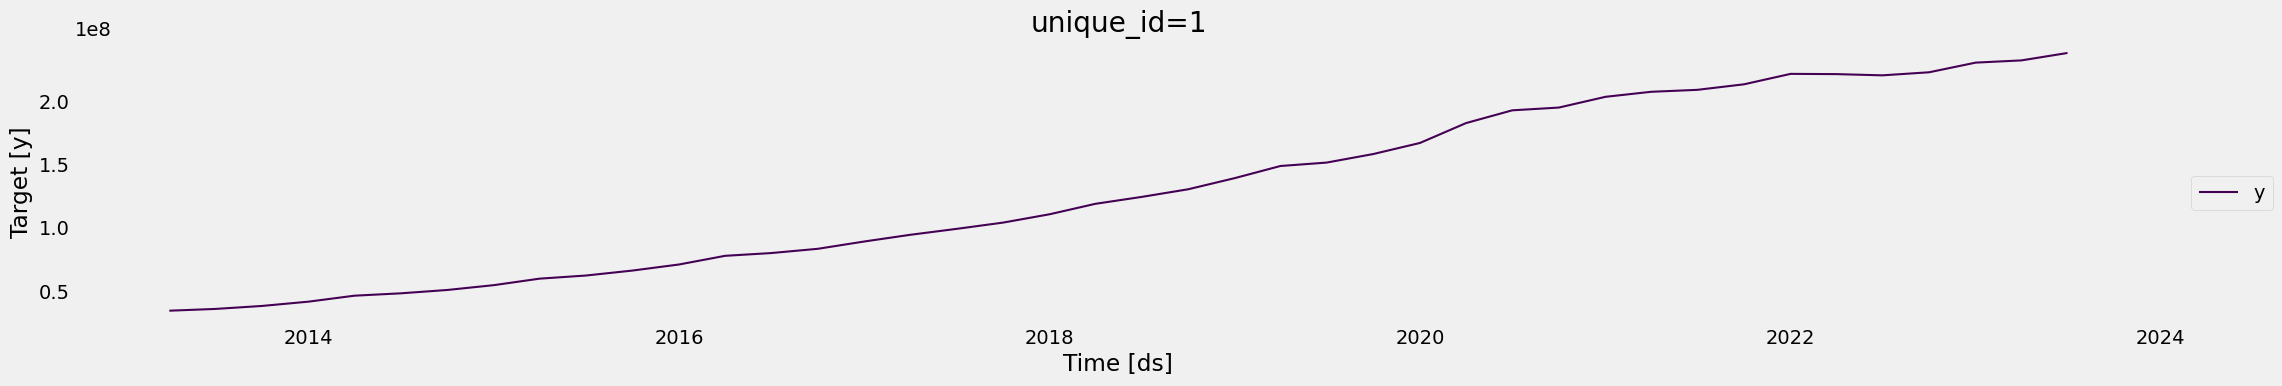

In [17]:
plot_series(data)

Now let’s have a look at the quarterly growth rate of subscribers at Netflix

In [19]:
# Calculate the quarterly growth rate
data['Quarterly Growth Rate'] = data['y'].pct_change() * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data['Bar Color'] = data['Quarterly Growth Rate'].apply(lambda x: 'green' if x > 0 else 'red')

In [22]:
# Plot the quarterly growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['ds'],
    y=data['Quarterly Growth Rate'],
    marker_color=data['Bar Color'],
    name='Quarterly Growth Rate'
))
fig.update_layout(title='Netflix Quarterly Subscriptions Growth Rate',
                  xaxis_title='Time Period',
                  yaxis_title='Quarterly Growth Rate (%)')
fig.show()

Now let’s have a look at the yearly growth rate

In [23]:
# Calculate the yearly growth rate
data['Year'] = data['ds'].dt.year
yearly_growth = data.groupby('Year')['y'].pct_change().fillna(0) * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data['Bar Color'] = yearly_growth.apply(lambda x: 'green' if x > 0 else 'red')

In [24]:
# Plot the yearly subscriber growth rate using bar graphs
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data['Year'],
    y=yearly_growth,
    marker_color=data['Bar Color'],
    name='Yearly Growth Rate'
))
fig.update_layout(title='Netflix Yearly Subscriber Growth Rate',
                  xaxis_title='Year',
                  yaxis_title='Yearly Growth Rate (%)')

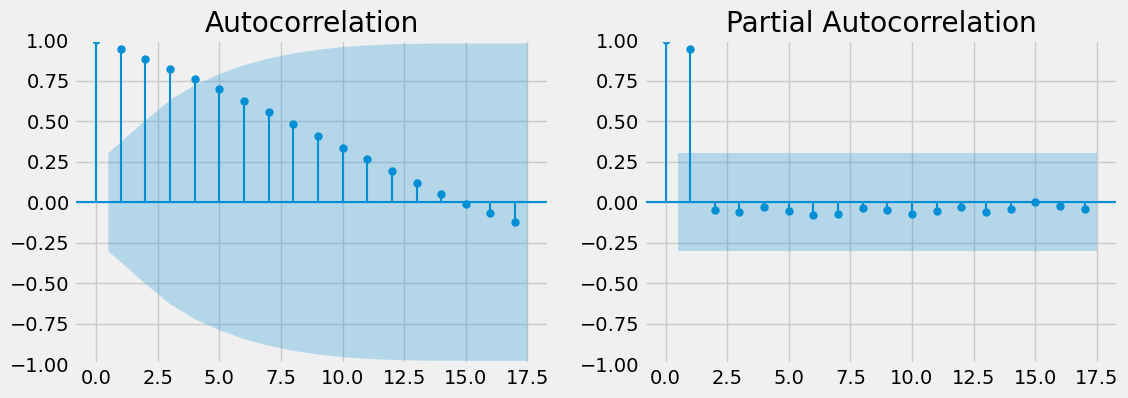

In [25]:
# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data["y"], ax=axes[0])
plot_pacf(data["y"], ax=axes[1])
plt.show()

# **Split the data into training and testing** <a id="4"></a>

Let's divide our data into two parts:

1. Data to train the model.
2. Data to test the model, here we will use the last 6 quarter.

In [55]:
df=data[["ds","y","unique_id"]]

In [56]:
train = df[df.ds<='2022-01-01'] 
test=df[(df['ds'] > '2022-01-01')]

train.shape, test.shape

((36, 3), (6, 3))

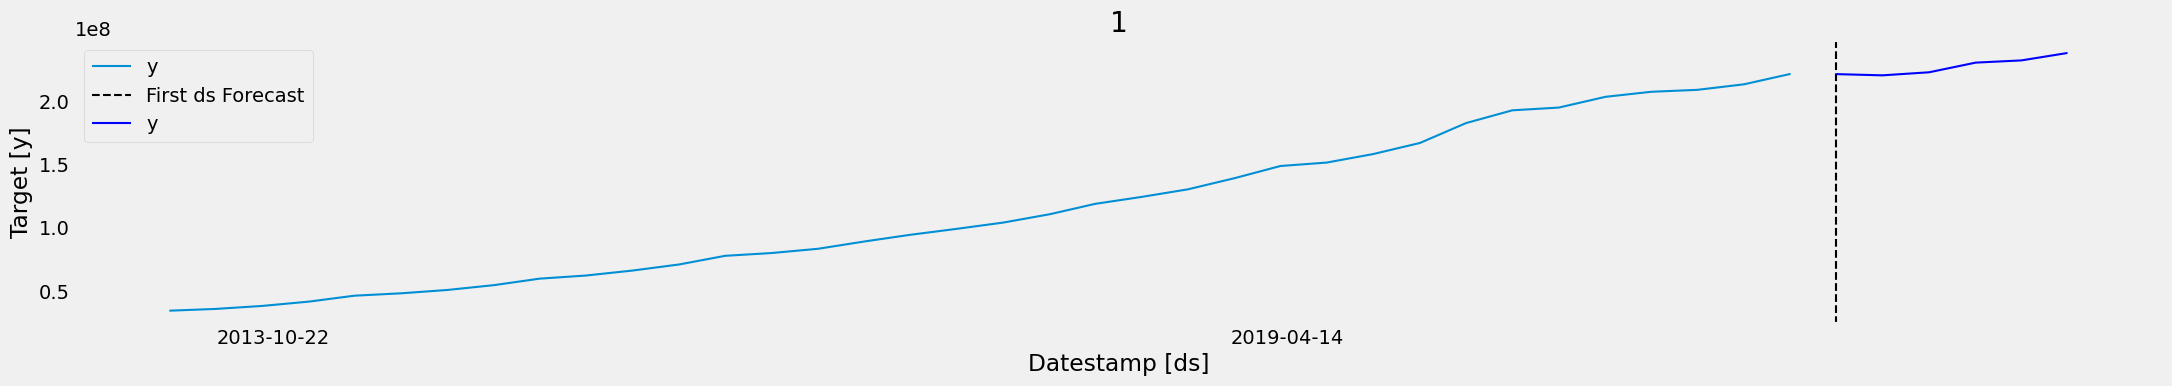

In [94]:
StatsForecast.plot(train, test)

# **Implementation with StatsForecast** <a id="5"></a> 



In [57]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, SeasonalNaive, AutoCES, AutoETS, SimpleExponentialSmoothingOptimized,Holt, AutoTheta,SeasonalExponentialSmoothingOptimized

In [83]:
season_length = 4 # Quarterly data 
horizon = 6 # number of predictions

# We call the model that we are going to use
models = [       
          SeasonalNaive(season_length=season_length),
          SeasonalExponentialSmoothingOptimized(season_length=season_length),
          SimpleExponentialSmoothingOptimized()
          ]

In [84]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    df=train,
    models=models,
    freq='QS', 
    n_jobs=-1)

## **Fit the Model**

In [85]:
sf.fit()

StatsForecast(models=[SeasonalNaive,SeasESOpt,SESOpt])

## **Predict Method**

In [86]:
Y_hat = sf.predict(horizon)
Y_hat

,ds,SeasonalNaive,SeasESOpt,SESOpt
unique_id,,,,
1,2022-04-01,207640000.0,207388768.0,221756768.0
1,2022-07-01,209180000.0,209013536.0,221756768.0
1,2022-10-01,213560000.0,213372192.0,221756768.0
1,2023-01-01,221840000.0,221654512.0,221756768.0
1,2023-04-01,207640000.0,207388768.0,221756768.0
1,2023-07-01,209180000.0,209013536.0,221756768.0


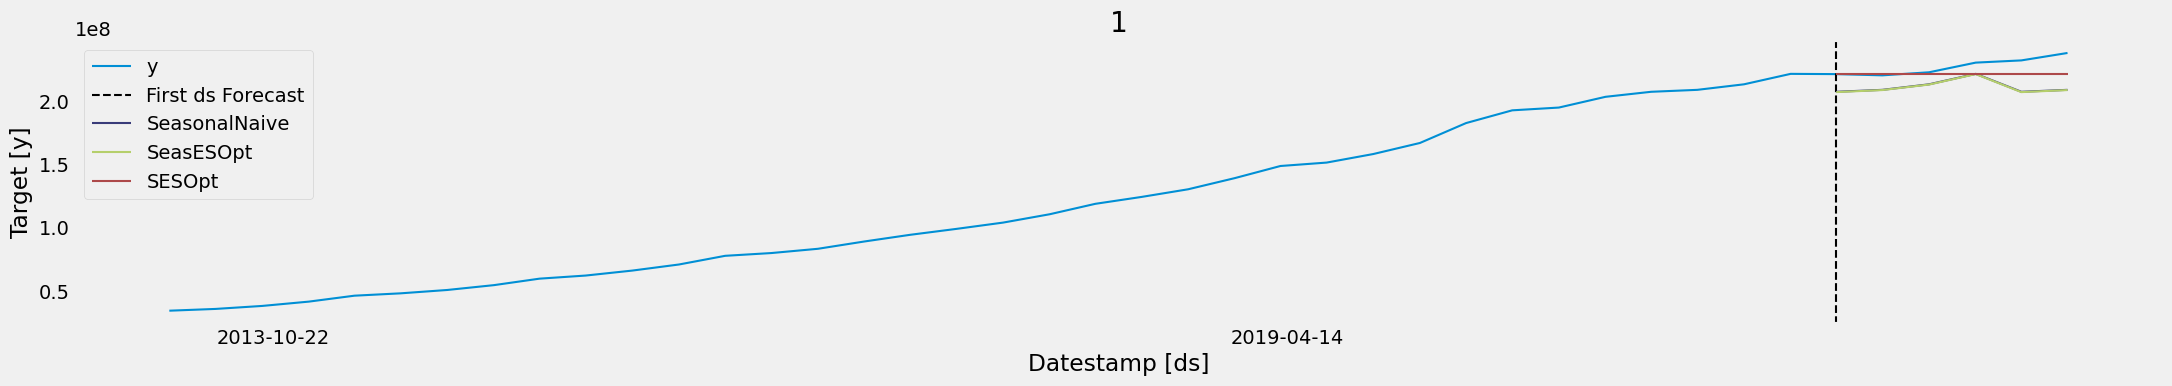

In [87]:
sf.plot(df, Y_hat)

# **Evaluate the model** <a id="6"></a> 

[Table of Contents](#0.1)

In [88]:
from datasetsforecast.losses import (mae, mape, mase, rmse, smape)
from utilsforecast.evaluation import evaluate

In [89]:
def evaluate_performace(y_hist, y_true, y_pred, models):
    y_true = pd.merge(y_true,y_pred, how='left', on=['ds'])
    evaluation = {}
    for model in models:
        evaluation[model] = {}
        for metric in [mase, mae, mape, rmse, smape]:
            metric_name = metric.__name__
            if metric_name == 'mase':
                evaluation[model][metric_name] = metric(y_true['y'].values,
                                                 y_true[model].values,
                                                 y_hist['y'].values, seasonality=24)
            else:
                evaluation[model][metric_name] = metric(y_true['y'].values, y_true[model].values)
    return pd.DataFrame(evaluation).T

In [92]:
evaluate_performace(train, test ,Y_hat.reset_index() , models=["SeasonalNaive","SeasESOpt","SESOpt"])
                                                               

,mase,mae,mape,rmse,smape
SeasonalNaive,0.119109,1.633333e+07,7.100344,1.811755e+07,7.420017
SeasESOpt,0.120578,1.653478e+07,7.188884,1.830157e+07,7.515349
SESOpt,0.047287,6.484411e+06,2.773041,8.906289e+06,2.846294


# **Conclusion** <a id="7"></a> 

Based on the results obtained for the forecast of Netflix user subscriptions using the SeasonalNaive, SeasESOpt and SESOpt models, we can conclude the following:

1. Accuracy metrics: According to the accuracy metrics such as MASE, MAE, MAPE, RMSE and sMAPE, the three models have relatively good performance in forecasting Netflix user subscriptions. The values for these metrics are generally low, indicating that the forecasts fit well with actual subscription values.

2. SeasonalNaive and SeasESOpt: The SeasonalNaive and SeasESOpt models show similar results in terms of the evaluated accuracy metrics. Both models have close values in the MASE, MAE, MAPE, RMSE and sMAPE. This suggests that both models are able to capture seasonal patterns and trends in Netflix user subscription data effectively.

3. SESOpt: The SESOpt model shows the best results compared to the other two models in all accuracy metrics. The MASE, MAE, MAPE, RMSE, and sMAPE are significantly lower in the SESOpt model, indicating higher accuracy in forecasting Netflix user subscriptions.

4. Best model: According to the results provided, the SESOpt model is the one that shows the best performance in forecasting Netflix user subscriptions. This model uses a simple exponential smoothing approach and achieves higher accuracy compared to the other two models evaluated.

In summary, the results indicate that the SeasonalNaive, SeasESOpt and SESOpt models are capable of making reasonably accurate forecasts of Netflix user subscriptions. However, the SESOpt model shows the best performance in terms of the evaluated accuracy metrics. These results demonstrate the usefulness of time series forecasting models in predicting Netflix user subscriptions, which can be valuable for decision making and strategic planning in the company.

# **References** <a class="anchor" id="8"></a>

[Table of Contents](#0.1)

1. Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python. 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#multiple-seasonalities).
5. [Model MTSL](https://nixtla.github.io/statsforecast/docs/models/multipleseasonaltrend.html)
6. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
7. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
8. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).